# You Can download the dataset from here : https://www.kaggle.com/datasets/kazanova/sentiment140

# Import the Necessary Dependencies

In [1]:
import re
import numpy as np
import pandas as pd

import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

from nltk.stem import WordNetLemmatizer

from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

# Read and Load the Dataset

In [2]:
DATASET_COLUMNS=['target','ids','date','flag','user','text']
DATASET_ENCODING = "ISO-8859-1"

In [3]:
df = pd.read_csv('Project_Data.csv', encoding=DATASET_ENCODING, names=DATASET_COLUMNS)
df.sample(5)

,target,ids,date,flag,user,text
1251784,4,1996577085,Mon Jun 01 15:19:13 PDT 2009,NO_QUERY,worldofok,Thank you to all our new followers. If you ha...
624054,0,2229767087,Thu Jun 18 16:10:40 PDT 2009,NO_QUERY,DkW_2023,"Still awake, Thanks to Star Trek novels being ..."
1499330,4,2070788445,Sun Jun 07 18:17:55 PDT 2009,NO_QUERY,x_teamcullen_x,making pokemon macaroni and cheese
397591,0,2056670837,Sat Jun 06 11:34:33 PDT 2009,NO_QUERY,davidecorradi,Saturday night fever...proper fever..
1460688,4,2063864529,Sun Jun 07 04:22:35 PDT 2009,NO_QUERY,chiniehdiaz,@jasonlmoore Yes you were! *extra hug*


# EDA

In [4]:
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [5]:
df.columns

Index(['target', 'ids', 'date', 'flag', 'user', 'text'], dtype='object')

In [6]:
print('length of data :', len(df))

length of data : 1600000


In [7]:
df.shape

(1600000, 6)

In [8]:
print('Count of columns in the data is:  ', len(df.columns))
print('Count of rows in the data is:  ', len(df))

Count of columns in the data is:   6
Count of rows in the data is:   1600000


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [10]:
df.dtypes

target     int64
ids        int64
date      object
flag      object
user      object
text      object
dtype: object

In [11]:
np.sum(df.isnull().any(axis=1))

0

In [12]:
df['target'].unique()

array([0, 4], dtype=int64)

In [13]:
df['target'].nunique()

2

## Data Visualization of Target Variables

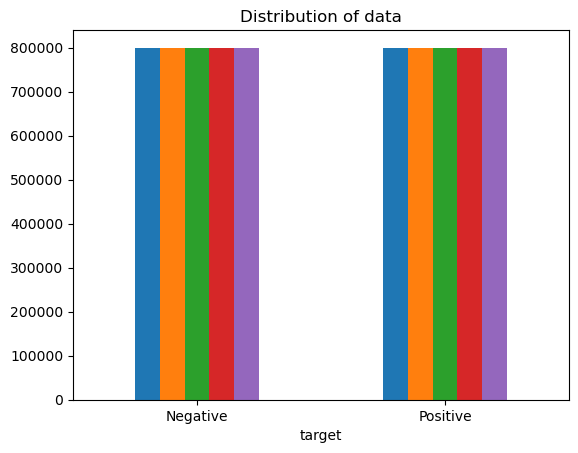

In [14]:
# Plotting the distribution for dataset.
ax = df.groupby('target').count().plot(kind='bar', title='Distribution of data',legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)

# Storing data in lists.
text, sentiment = list(df['text']), list(df['target'])

<Axes: xlabel='target', ylabel='count'>

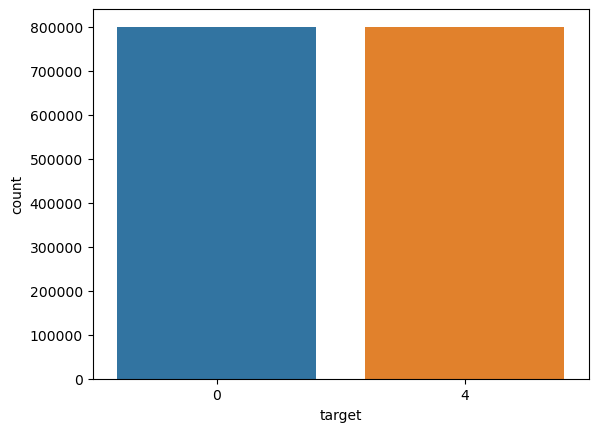

In [15]:
sns.countplot(x='target', data=df)

#  Data Preprocessing

In [16]:
#Selecting the text and Target column for our further analysis
data=df[['text','target']]

In [17]:
#Replacing the values to ease understanding. (Assigning 1 to Positive sentiment 4)
data.loc[:, 'target'] = data['target'].replace(4, 1)

In [18]:
#Printing unique values of target variables
data['target'].unique()

array([0, 1], dtype=int64)

In [19]:
#Separating positive and negative tweets
data_pos = data[data['target'] == 1]
data_neg = data[data['target'] == 0]

### Taking one-fourth of the data so we can run it on our machine easily

In [20]:
data_pos = data_pos.iloc[:int(20000)]
data_neg = data_neg.iloc[:int(20000)]

In [21]:
#Combining positive and negative tweets
dataset = pd.concat([data_pos, data_neg])

In [22]:
#Making statement text in lowercase
dataset['text']=dataset['text'].str.lower()
dataset['text'].tail()

19995    not much time off this weekend, work trip to m...
19996                            one more day of holidays 
19997    feeling so down right now .. i hate you damn h...
19998    geez,i hv to read the whole book of personalit...
19999    i threw my sign at donnie and he bent over to ...
Name: text, dtype: object

In [23]:
#Defining set containing all stopwords in English
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're','s', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [24]:
#Cleaning and removing the above stop words list from the tweet text
STOPWORDS = set(stopwordlist)
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
dataset['text'] = dataset['text'].apply(lambda text: cleaning_stopwords(text))
dataset['text'].head()

800000                love @health4uandpets u guys r best!!
800001    im meeting one besties tonight! cant wait!! - ...
800002    @darealsunisakim thanks twitter add, sunisa! g...
800003    sick really cheap hurts much eat real food plu...
800004                      @lovesbrooklyn2 effect everyone
Name: text, dtype: object

### removing punctuations

In [25]:
import string
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)
dataset['text']= dataset['text'].apply(lambda x: cleaning_punctuations(x))
dataset['text'].tail()

19995    not much time off weekend work trip malmï¿½ fr...
19996                                     one day holidays
19997                     feeling right  hate damn humprey
19998    geezi hv read whole book personality types emb...
19999    threw sign donnie bent over get but thingee ma...
Name: text, dtype: object

### removing repeating characters

In [26]:
def cleaning_repeating_char(text):
    return re.sub(r'(.)1+', r'1', text)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_repeating_char(x))
dataset['text'].tail()

19995    not much time off weekend work trip malmï¿½ fr...
19996                                     one day holidays
19997                     feeling right  hate damn humprey
19998    geezi hv read whole book personality types emb...
19999    threw sign donnie bent over get but thingee ma...
Name: text, dtype: object

### removing URLs

In [27]:
def cleaning_URLs(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',data)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_URLs(x))
dataset['text'].tail()

19995    not much time off weekend work trip malmï¿½ fr...
19996                                     one day holidays
19997                     feeling right  hate damn humprey
19998    geezi hv read whole book personality types emb...
19999    threw sign donnie bent over get but thingee ma...
Name: text, dtype: object

### removing numeric numbers

In [28]:
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_numbers(x))
dataset['text'].tail()

19995    not much time off weekend work trip malmï¿½ fr...
19996                                     one day holidays
19997                     feeling right  hate damn humprey
19998    geezi hv read whole book personality types emb...
19999    threw sign donnie bent over get but thingee ma...
Name: text, dtype: object

### tokenization of tweet text

In [29]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'w+')
dataset['text'] = dataset['text'].apply(tokenizer.tokenize)
dataset['text'].head()

800000           []
800001          [w]
800002    [w, w, w]
800003           []
800004           []
Name: text, dtype: object

### stemming

In [30]:
import nltk
st = nltk.PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data
dataset['text']= dataset['text'].apply(lambda x: stemming_on_text(x))
dataset['text'].head()

800000           []
800001          [w]
800002    [w, w, w]
800003           []
800004           []
Name: text, dtype: object

### Applying lemmatizer

In [31]:
lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return data
dataset['text'] = dataset['text'].apply(lambda x: lemmatizer_on_text(x))
dataset['text'].head()

800000           []
800001          [w]
800002    [w, w, w]
800003           []
800004           []
Name: text, dtype: object

###  Separating input feature and label

In [32]:
X=data.text
y=data.target

### Plot a cloud of words for negative tweets

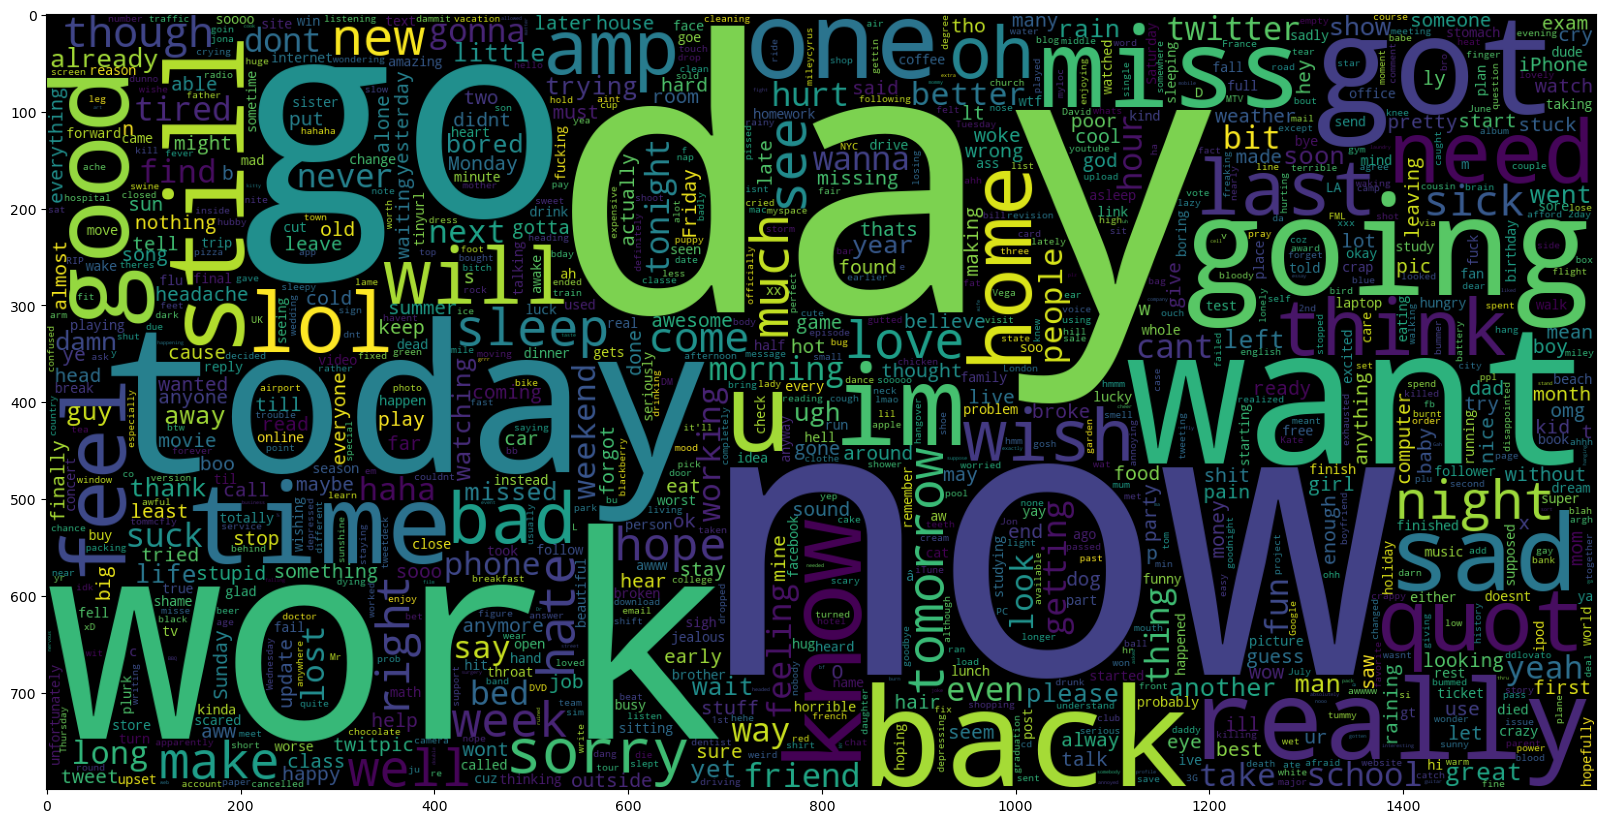

In [33]:
data_neg = data['text'][:800000]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

### Plot a cloud of words for positive tweets

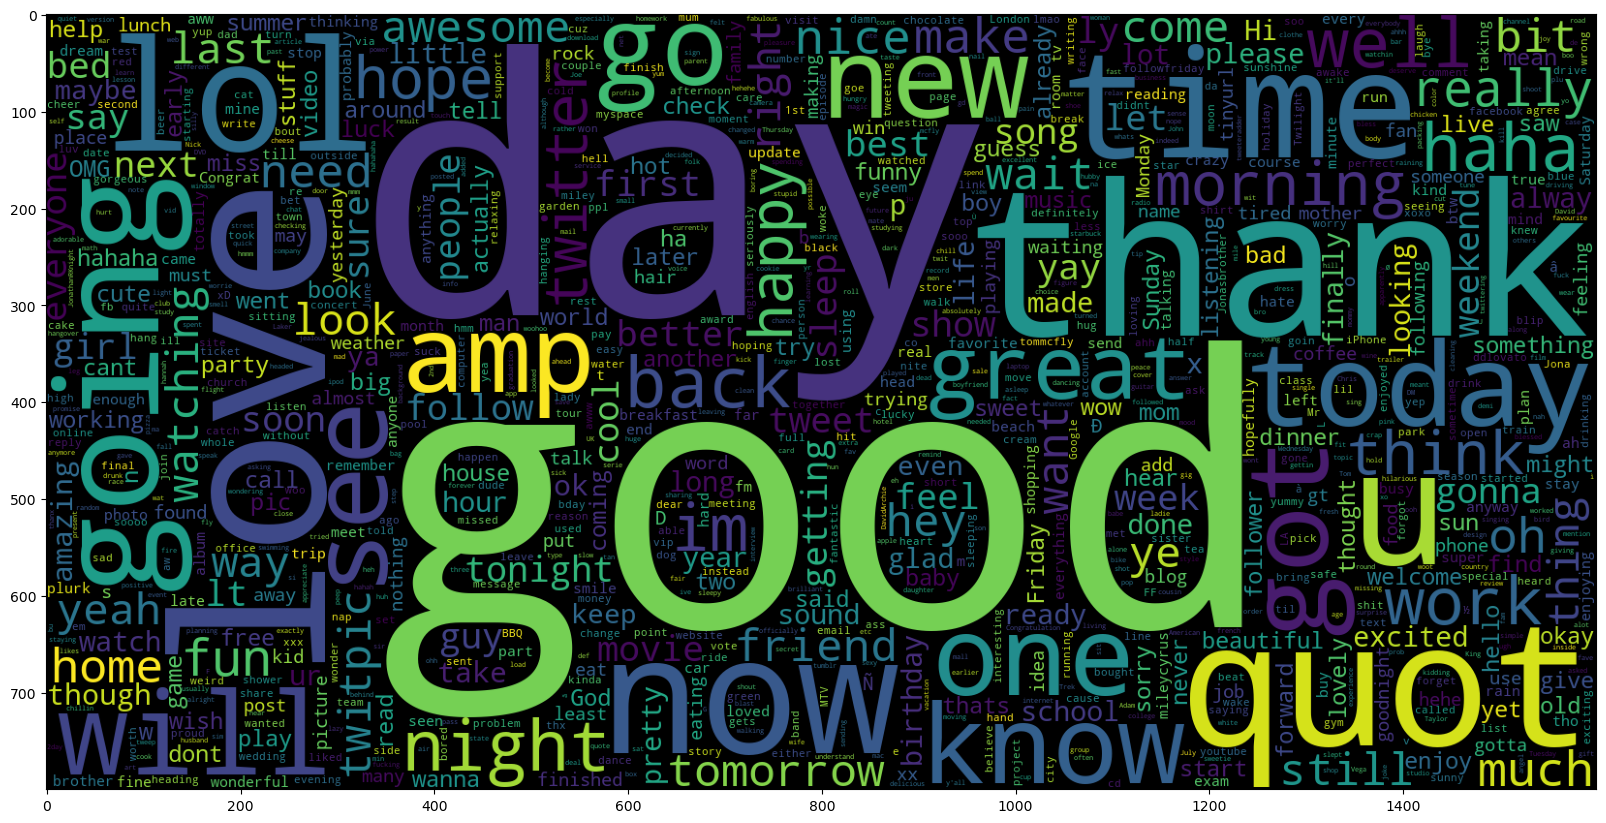

In [34]:
data_pos = data['text'][800000:]
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
              collocations=False).generate(" ".join(data_pos))
plt.figure(figsize = (20,20))
plt.imshow(wc)

# Splitting Our Data Into Train and Test Subsets

In [35]:
# Separating the 95% data for training data and 5% for testing data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.05, random_state =26105111)

# Transforming the Dataset Using TF-IDF Vectorizer

In [36]:
vectoriser = TfidfVectorizer(ngram_range=(1, 2), max_features=500000)
vectoriser.fit(X_train)
print('No. of feature_words: ', len(vectoriser.get_feature_names_out()))

No. of feature_words:  500000


In [37]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)

# Function for Model Evaluation

In [38]:
def model_Evaluate(model):
    # Predict values for Test dataset
    y_pred = model.predict(X_test)
    
    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)
    categories = ['Negative', 'Positive']
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)
    
    sns.heatmap(cf_matrix, annot=labels, cmap='Blues', fmt='',
                xticklabels=categories, yticklabels=categories)
    plt.xlabel("Predicted values", fontdict={'size': 14}, labelpad=10)
    plt.ylabel("Actual values", fontdict={'size': 14}, labelpad=10)
    plt.title("Confusion Matrix", fontdict={'size': 18}, pad=20)
    plt.show()

# Model Building

              precision    recall  f1-score   support

           0       0.81      0.79      0.80     40100
           1       0.80      0.81      0.80     39900

    accuracy                           0.80     80000
   macro avg       0.80      0.80      0.80     80000
weighted avg       0.80      0.80      0.80     80000



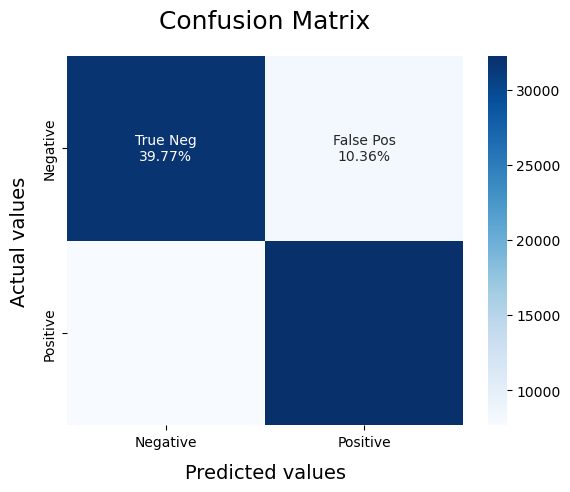

In [39]:
BNBmodel = BernoulliNB()
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)
y_pred1 = BNBmodel.predict(X_test)

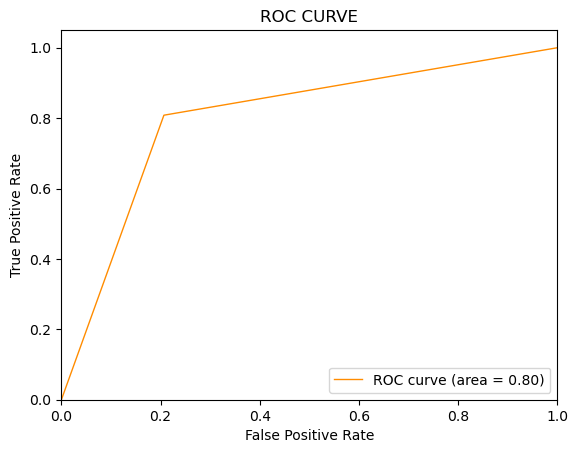

In [40]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred1)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

C:\Anaconda\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.82      0.81      0.81     40100
           1       0.81      0.82      0.82     39900

    accuracy                           0.82     80000
   macro avg       0.82      0.82      0.82     80000
weighted avg       0.82      0.82      0.82     80000



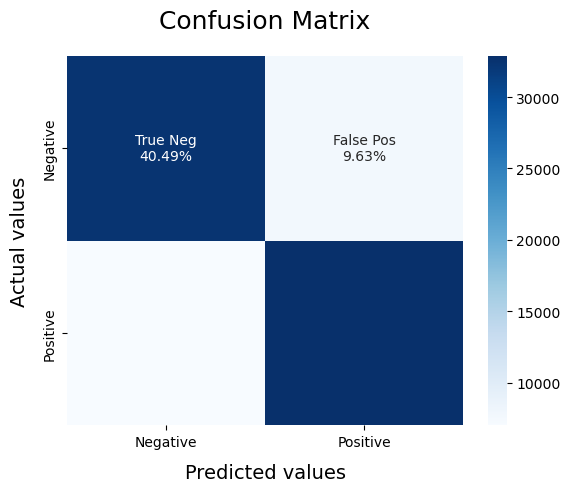

In [41]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)
y_pred2 = SVCmodel.predict(X_test)

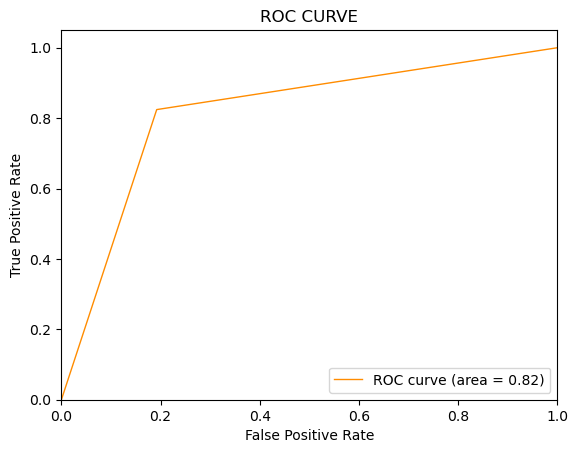

In [42]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred2)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

              precision    recall  f1-score   support

           0       0.83      0.81      0.82     40100
           1       0.81      0.83      0.82     39900

    accuracy                           0.82     80000
   macro avg       0.82      0.82      0.82     80000
weighted avg       0.82      0.82      0.82     80000



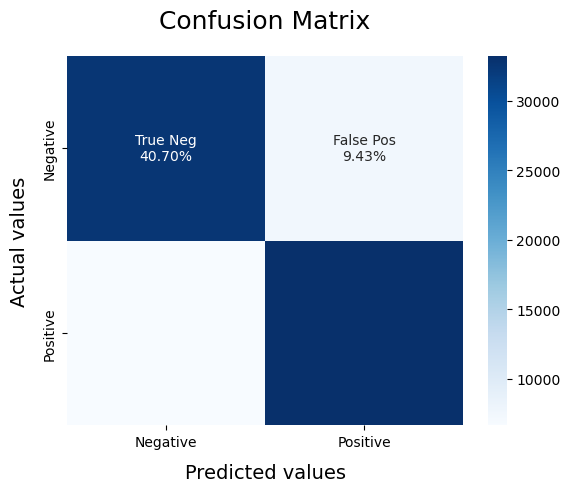

In [43]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)
y_pred3 = LRmodel.predict(X_test)

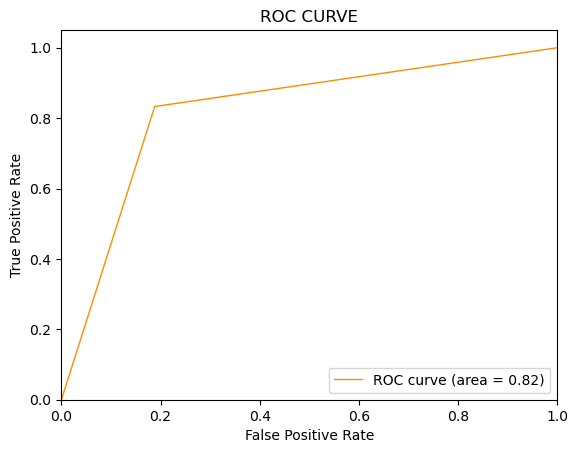

In [44]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred3)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()